In [4]:
# Chap3

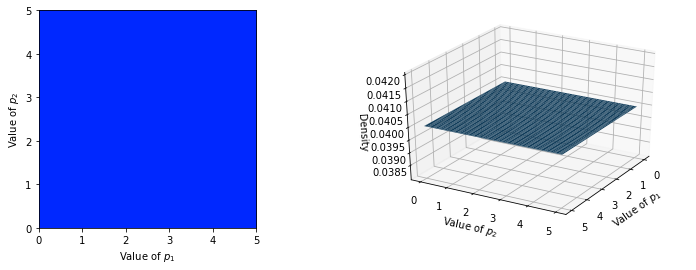

In [5]:
import scipy.stats as stats
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np

figsize(12.5, 4)
from mpl_toolkits.mplot3d import Axes3D

jet = plt.cm.jet
fig = plt.figure()

x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)

M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlabel("Value of $p_1$")
plt.ylabel("Value of $p_2$")

ax = plt.subplot(122, projection='3d')
ax.plot_surface(X, Y, M, vmax=1, vmin=.15)
ax.view_init(azim=390)
ax.set_xlabel("Value of $p_1$")
ax.set_ylabel("Value of $p_2$")
ax.set_zlabel("Density")

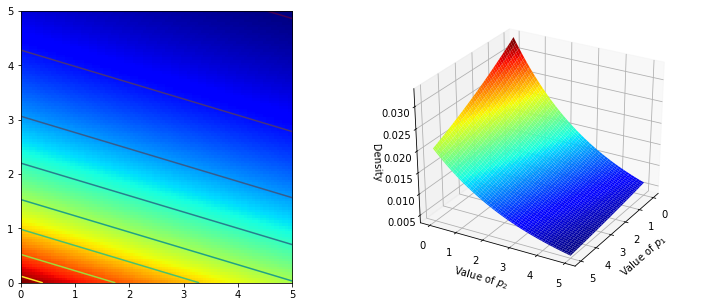

In [6]:
figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(y, scale=10)

M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
ax.set_xlabel("Value of $p_1$")
ax.set_ylabel("Value of $p_2$")
ax.set_zlabel("Density")

In [7]:
N=1
lambda_1_true = 1
lambda_2_true = 3

data = np.concatenate(
    [
        stats.poisson.rvs(lambda_1_true, size=(N, 1)),
        stats.poisson.rvs(lambda_2_true, size=(N, 1)),
    ], axis=1)

print(data)

x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x) for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y) for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :]) # likelihood

[[1 4]]


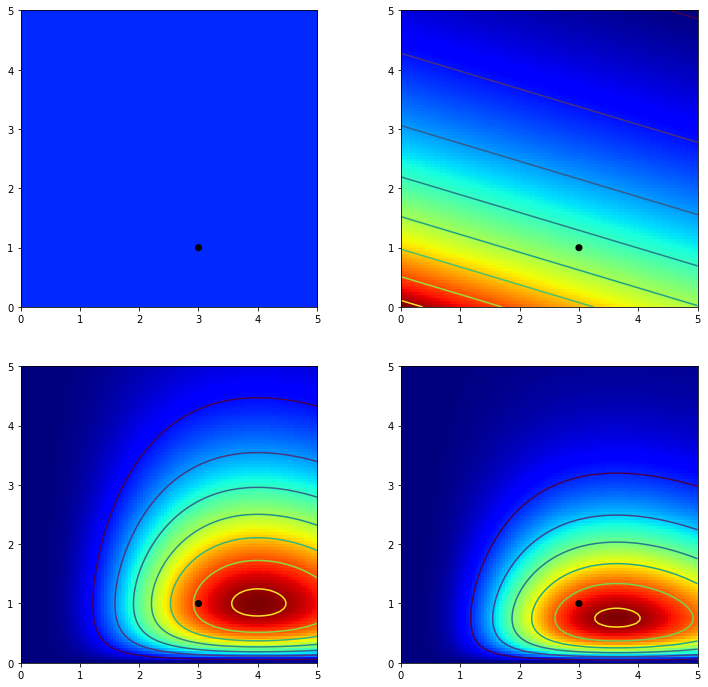

In [8]:
figsize(12.5, 12)

plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")

plt.subplot(223)
plt.contour(x, y, M*L)
plt.imshow(M*L, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")

plt.subplot(222)
exp_x = stats.expon.pdf(x, scale=3)
exp_y = stats.expon.pdf(y, scale=10)

M = np.dot(exp_x[:, None], exp_y[None, :])
CS = plt.contour(X, Y, M)
im = plt.imshow(M, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")


plt.subplot(224)
plt.contour(x, y, M*L)
plt.imshow(M*L, interpolation='none', origin='lower', cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")


In [9]:
from os import makedirs
makedirs("data", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXt6b", "data/mixture_data.csv")

('data/mixture_data.csv', <http.client.HTTPMessage at 0x7f958f191978>)

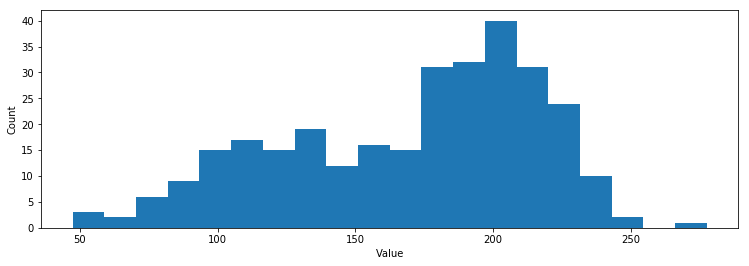

In [10]:
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=',')
plt.hist(data, bins=20, histtype='stepfilled')

plt.ylim([0, None])
plt.xlabel('Value')
plt.ylabel('Count')

In [17]:
import pymc as pm
p = pm.Uniform("p", 0., 1.)
assignment = pm.Categorical("assignment", [p, 1-p], size=data.shape[0])

print("prior assignment, with p = %.2f: " % p.value)
print(assignment.value[:100])

prior assignment, with p = 0.11: 
[1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]


In [18]:
# 2つのtauを1つのPyMC変数で表現
taus = 1.0 / pm.Uniform("stds", 0, 33, size=2) ** 2

# 標準偏差10=制度0.01の正規分布を仮定
centers = pm.Normal("centers", [120, 190], [0.01, 0.01], size=2)

# どちらの正規分布からサンプルするか選択し、その平均を取得
@pm.deterministic
def center_i(assignment=assignment, centers=centers):
    return centers[assignment]

# どちらの正規分布からサンプルするか選択し、その制度を取得
@pm.deterministic
def tau_i(assignment=assignment, taus=taus):
    return taus[assignment]

# このモデルとデータをひも付け
observations = pm.Normal("obs", center_i, tau_i, value=data, observed=True)

# Modelを作成
model = pm.Model([p, assignment, taus, centers])

# pm.sample(iterations) iterationsは反復回数
# 
mcmc = pm.MCMC(model)
mcmc.sample(50000)

 [-----------------100%-----------------] 50000 of 50000 complete in 19.9 sec

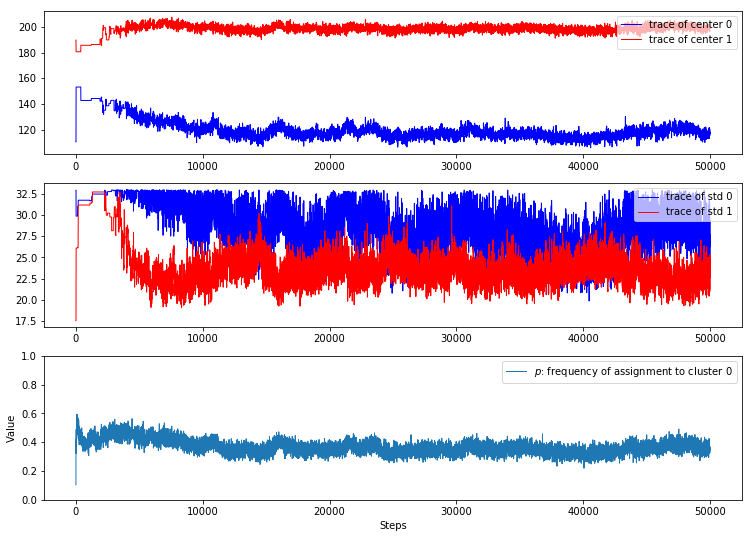

In [19]:
figsize(12.5, 9)
line_width=1

colors = ["red", "blue"]
center_trace = mcmc.trace("centers")[:]
if center_trace[-1, 0] < center_trace[-1, 1]:
    colors = ["blue", "red"]
    
plt.subplot(311)
plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=line_width)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=line_width)
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = mcmc.trace("stds")[:]
plt.plot(std_trace[:, 0], label="trace of std 0", c=colors[0], lw=line_width)
plt.plot(std_trace[:, 1], label="trace of std 1", c=colors[1], lw=line_width)
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(313)
p_trace = mcmc.trace("p")[:]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0", lw=line_width)

plt.xlabel("Steps")
plt.ylabel("Value")
plt.ylim(0, 1)
plt.legend()

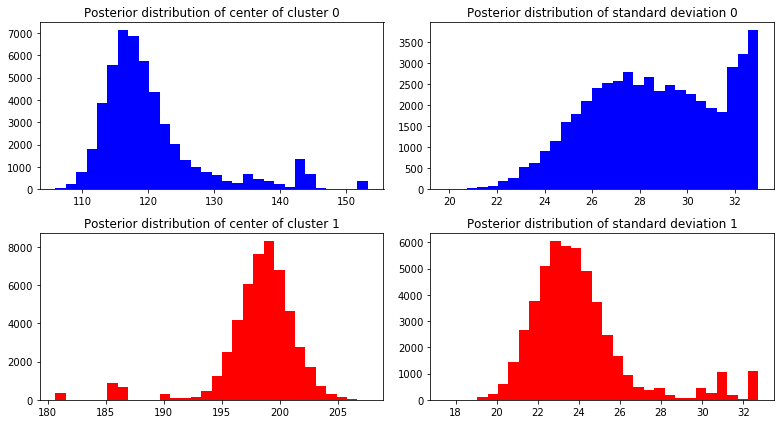

In [20]:
figsize(11.0, 6)
std_trace = mcmc.trace("stds")[:]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title("Posterior distribution of center of cluster %d" % i)
    plt.hist(center_trace[:, i], color=colors[i], bins=30, histtype='stepfilled')
    
    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title("Posterior distribution of standard deviation %d" % i)
    plt.hist(std_trace[:, i], color=colors[i], bins=30, histtype='stepfilled')
plt.tight_layout()
              

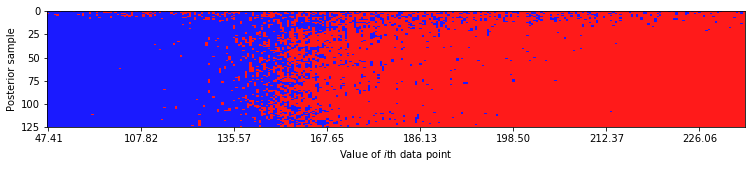

In [21]:
import matplotlib as mpl
figsize(12.5, 4.5)

plt.cmap = mpl.colors.ListedColormap(colors)

plt.imshow(mcmc.trace("assignment")[::400, np.argsort(data)], cmap=plt.cmap, aspect=.4, alpha=0.9)
plt.xticks(np.arange(0, data.shape[0], 40), ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("Posterior sample")
plt.xlabel("Value of $i$th data point")

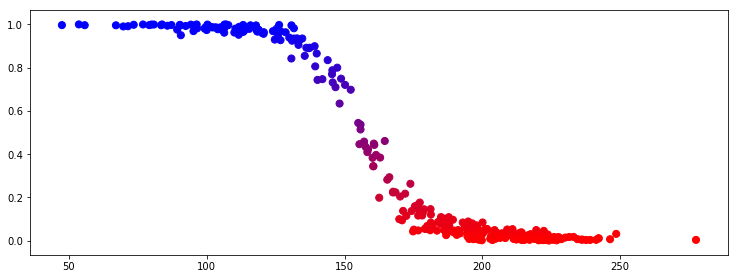

In [22]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = mcmc.trace("assignment")[:]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap, c=assign_trace.mean(axis=0), s=50)

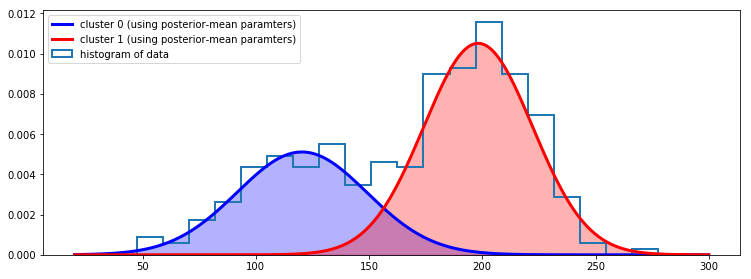

In [31]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = mcmc.trace("p")[:].mean(axis=0)

plt.hist(data, bins=20, histtype="step", normed=True, lw=2, label="histogram of data")

y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0], scale=posterior_std_means[0])
plt.plot(x, y, lw=3, color=colors[0], label="cluster 0 (using posterior-mean paramters)")
plt.fill_between(x, y, color=colors[0], alpha=0.3)

y = (1- posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1], scale=posterior_std_means[1])
plt.plot(x, y, lw=3, color=colors[1], label="cluster 1 (using posterior-mean paramters)")
plt.fill_between(x, y, color=colors[1], alpha=0.3)

plt.legend()

In [33]:
# predict class for new samples
norm_pdf = stats.norm.pdf

p_tace = mcmc.trace("p")[:]
x = 175 # new sample

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > (1-p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])
print("Probability of belonging to cluster 1: ", v.mean())

Probability of belonging to cluster 1:  6e-05


Plotting centers_0
Plotting centers_1
Plotting p
Plotting stds_0
Plotting stds_1


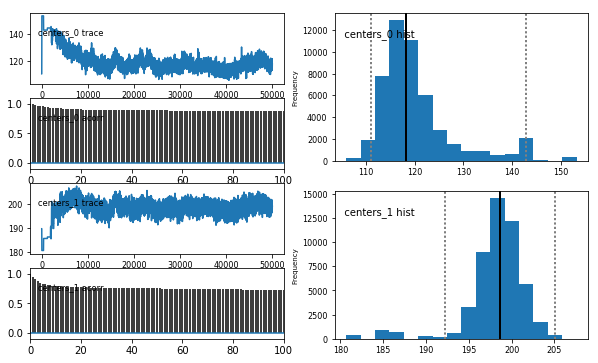

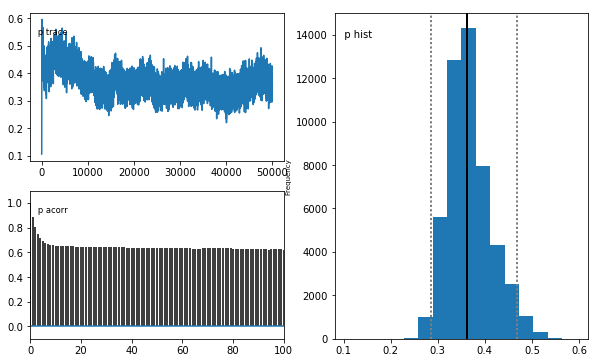

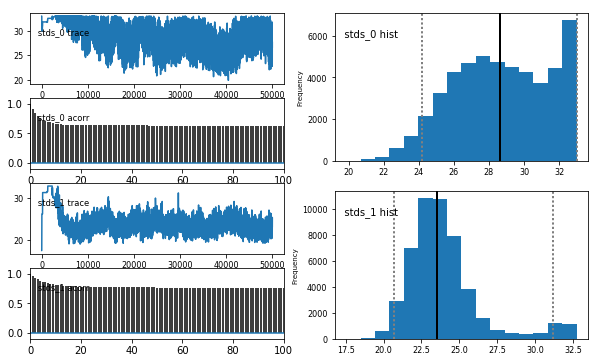

In [37]:
from pymc.Matplot import plot as mcplot
mcplot(mcmc, common_scale=False)